<a href="https://colab.research.google.com/github/YaninaK/anomaly-detection/blob/b1/notebooks/03_Test_modul_train_save_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обнаружение аномалий в начислениях за тепловую энергию


## 3. Cнижение/рост показаний в отдельные месяцы по сравнению с показаниями за предыдущие периоды по данному объекту.

(с учётом фактической температуры наружного воздуха и количества отопительных дней в месяце).


### Тестирование модуля ```scripts/train_save_model.py```

### Примеры аномалий

Виды аномалий по показаниям приборов учёта тепловой энергии, которые необходимо выявлять (кроме объектов с видом энергопотребления ГВС (централ):

1. нулевые значения показаний за тепловую энергию в отопительный период (октябрь-апрель);

2. равные значения показаний в течение нескольких расчетных периодов;

3. снижение/рост показаний в отдельные месяцы по сравнению с показаниями за предыдущие периоды по данному объекту (с учётом фактической температуры наружного воздуха и количества отопительных дней в месяце);

4. аномально низкое/высокое (отклонение более 25%) потребление объекта в конкретном месяце по сравнению с аналогичными объектами (только для типов объекта «Многоквартирный дом») по критериям:
  - год постройки (по группам до 1958 г., 1959-1989 гг., 1990-2000 гг., 2001-2010 гг., 2011-2024 гг.),
  - этажность (по группам 1-2 этажа, 3-4 этажа, 5-9 этажей,10-12 этажей, 13 и более этажей),
  - площадь (±10%),
  - наличие ГВС ИТП (горячей воды, учитываемой тем же прибором).

In [1]:
initiate = False
if initiate:
  !git init -q
  !git clone -b b1  https://github.com/YaninaK/anomaly-detection.git -q

  from google.colab import drive
  drive.mount('/content/drive')

  !unzip -u -q /content/drive/MyDrive/ML_projects/08_anomaly_detection/data/01_raw/task#3.zip -d /content/anomaly-detection/data/01_raw
  !cp /content/drive/MyDrive/ML_projects/08_anomaly_detection/models/* /content/anomaly-detection/models/

%cd /content/anomaly-detection/

/content/anomaly-detection


In [2]:
#!/usr/bin/env python3
"""Train and save model for Anomaly detection"""

import os
import sys

sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), ".."))

import argparse
import logging
from typing import Optional

import numpy as np
import pandas as pd
import tensorflow as tf

from src.anomaly_detection.data.make_dataset import load_data
from src.anomaly_detection.models.LSTM_model import get_model
from src.anomaly_detection.models.serialize import store
from src.anomaly_detection.models.train_autoencoder import \
    data_preprocessing_pipeline
from src.anomaly_detection.models.train_ethalon_model import \
    ethalon_model_data_preprocessing_pipeline

from scripts.train_save_model import train_store_autoencoder, train_store_ethalon_model
from src.anomaly_detection.models.serialize import load_model


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
logger = logging.getLogger()

METRICS = [
    tf.keras.metrics.MeanAbsoluteError(name="mae"),
    tf.keras.metrics.MeanAbsolutePercentageError(name="mape"),
    tf.keras.metrics.MeanSquaredError(name="mse"),
    tf.keras.metrics.RootMeanSquaredError(name="rmse"),
]
BATCH_SIZE = 128

output_autoencoder = ["autoencoder_v2", "autoencoder_training_history_v2"]
output_ethalon_model = ["ethalon_model_v1", "ethalon_model_training_history_v1"]

In [5]:
%%time
save = False
data, temperature, buildings = load_data(save=save)

CPU times: user 947 ms, sys: 67.9 ms, total: 1.01 s
Wall time: 1.06 s


In [6]:
%%time
ds_train, ds_valid, train_df, valid_df, df_seq, temperature, df_stat = (
        data_preprocessing_pipeline(data, temperature, buildings)
)

CPU times: user 18.9 s, sys: 358 ms, total: 19.2 s
Wall time: 19.5 s


In [7]:
%%time
regenerate = False
if regenerate:
  autoencoder = train_store_autoencoder(
      df_stat,
      ds_train,
      ds_valid,
      output_autoencoder,
      batch_size=BATCH_SIZE,
      n_epochs=200,
      steps_per_epoch=239,
  )
else:
  autoencoder = load_model(output_autoencoder[0])

CPU times: user 686 ms, sys: 9.37 ms, total: 695 ms
Wall time: 755 ms


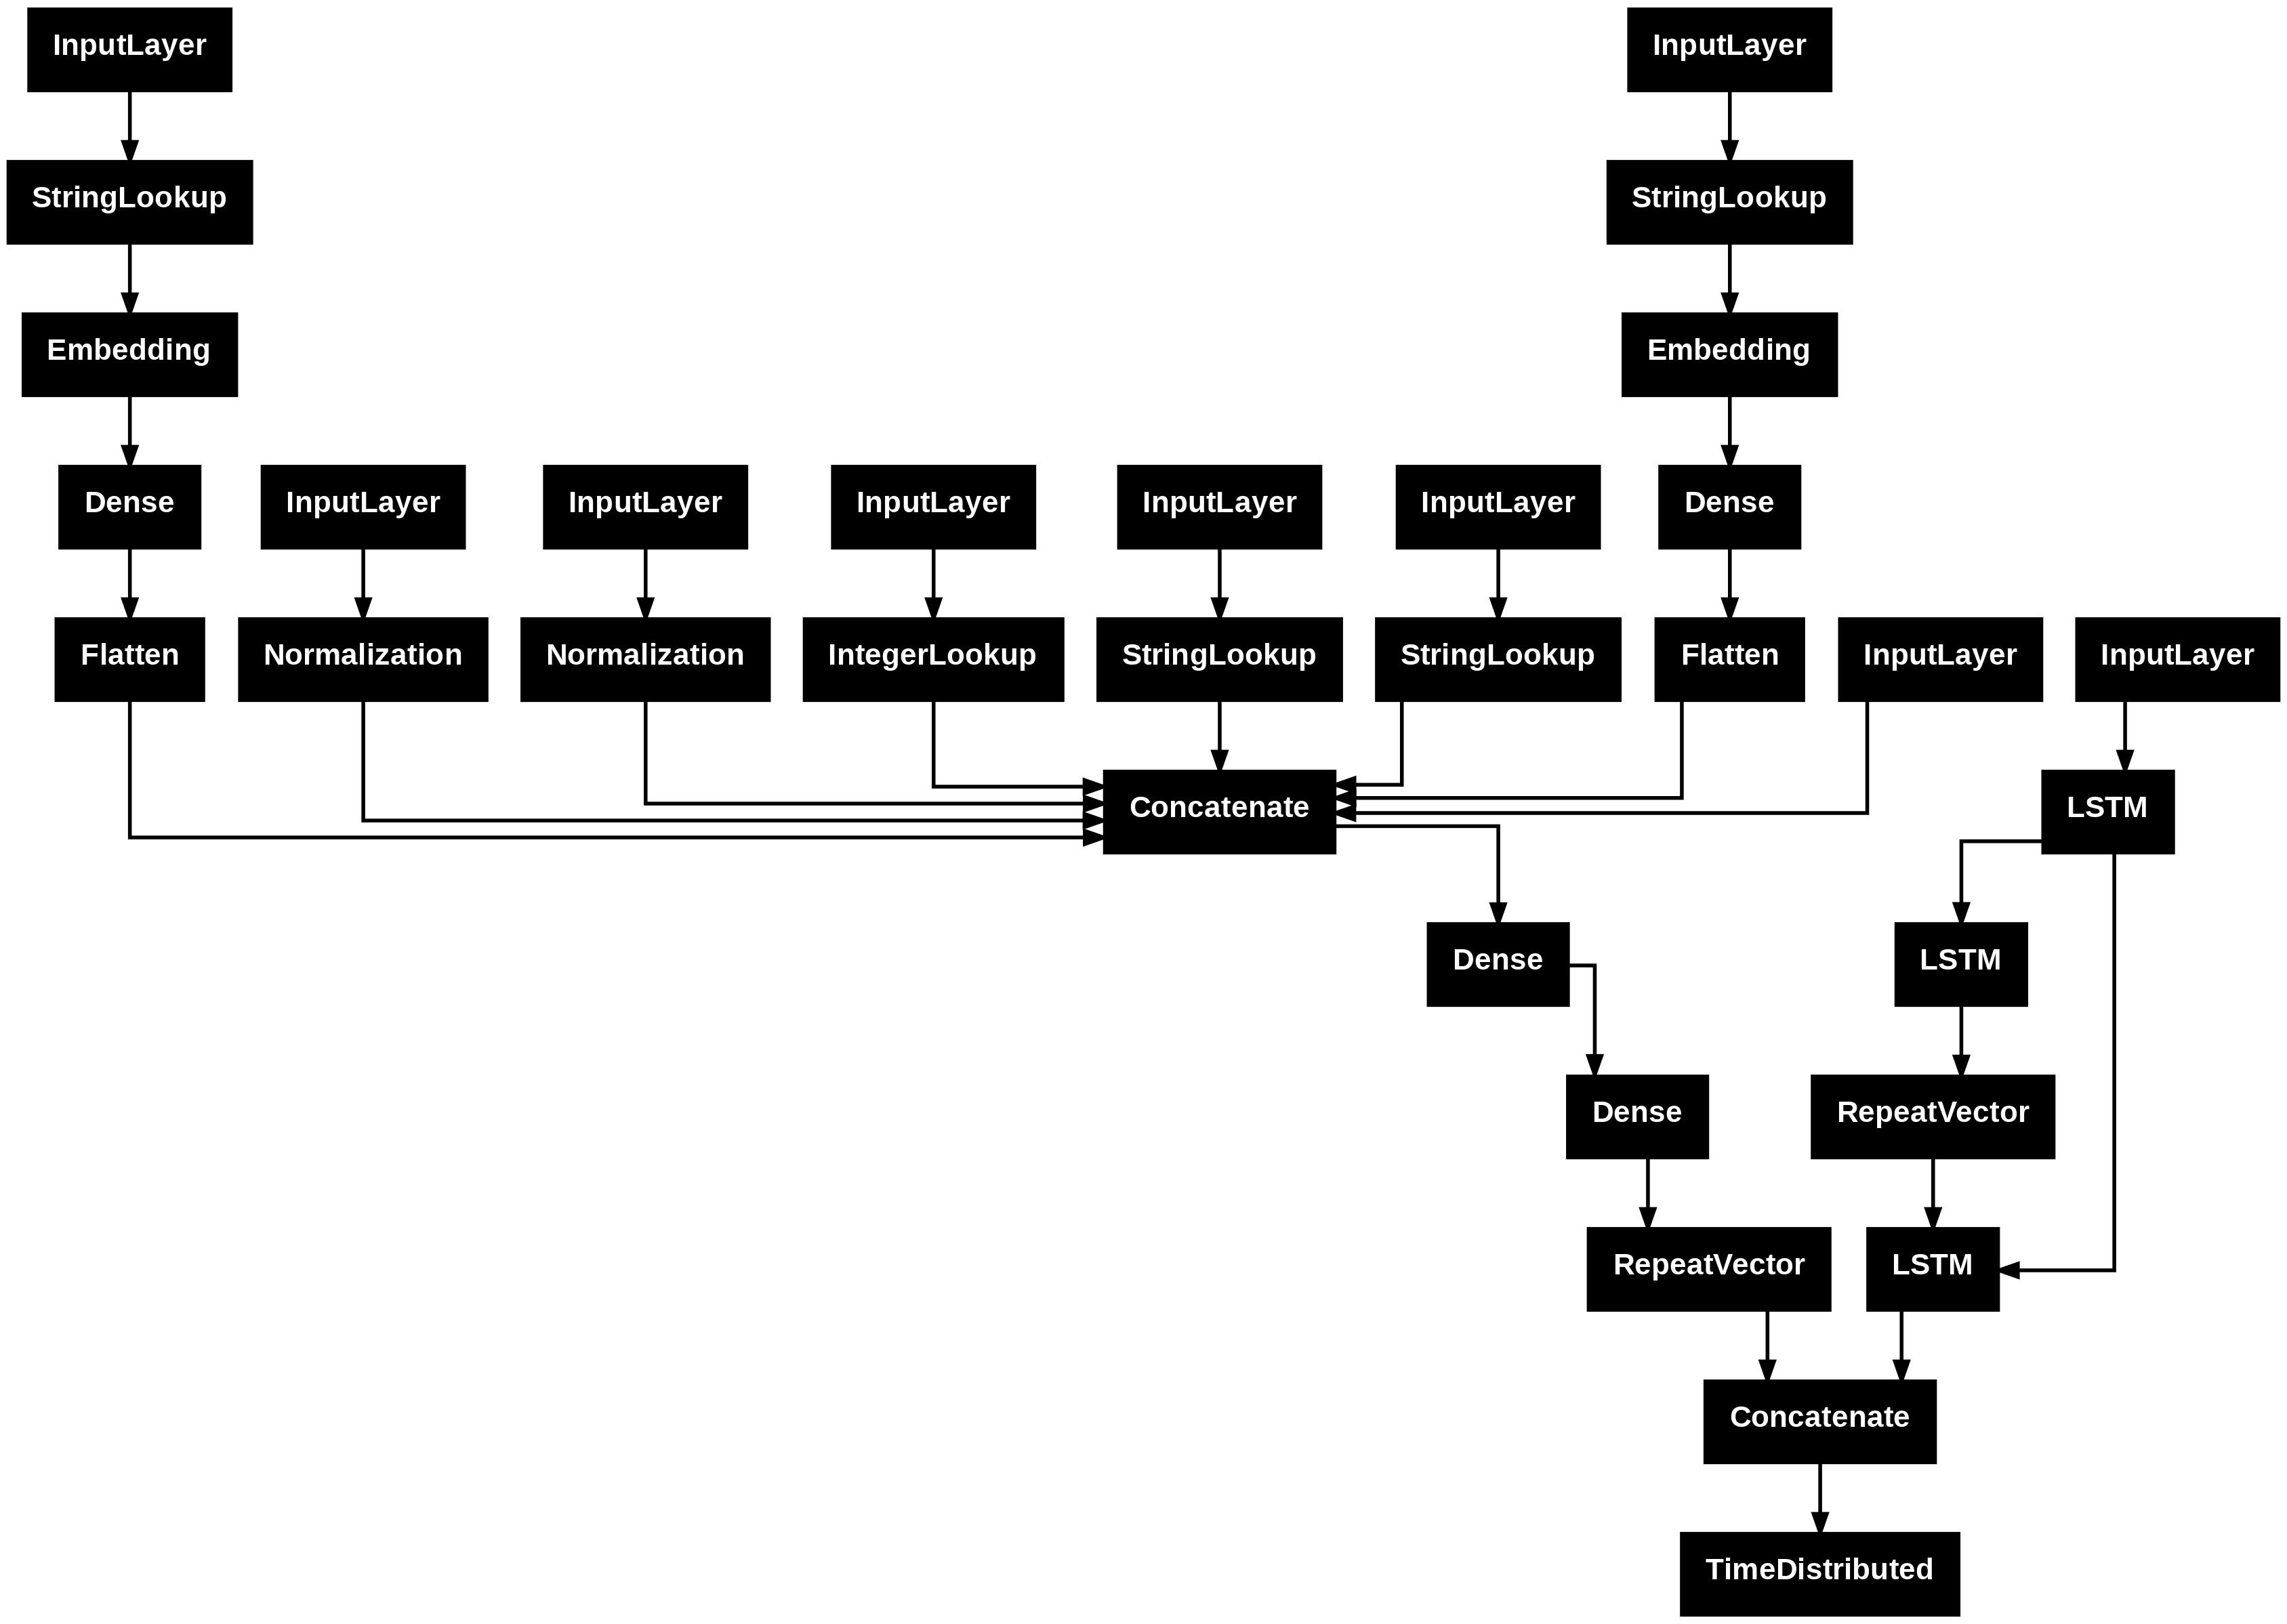

In [8]:
tf.keras.utils.plot_model(autoencoder)

In [9]:
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ object_type (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_prep          │ (None, 1)              │              0 │ object_type[0][0]      │
│ (StringLookup)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_prep               │ (None, 1)              │              0 │ street[0][0]           │
│ (StringLookup)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_emb           │ (None, 1, 5)           │            110 │ object_type_prep[0][0] │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_emb (Embedding)    │ (None, 1, 15)          │          3,315 │ street_prep[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ n_floors (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area (InputLayer)         │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_group (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_dense (Dense) │ (None, 1, 2)           │             12 │ object_type_emb[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ floor_group (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ year_group (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_dense (Dense)      │ (None, 1, 8)           │            128 │ street_emb[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LSTM input (InputLayer)   │ (None, 4, 3)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ n_floors_prep             │ (None, 1)              │              3 │ n_floors[0][0]         │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_prep (Normalization) │ (None, 1)              │              3 │ area[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_group_prep           │ (None, 11)             │              0 │ area_group[0][0]       │
│ (IntegerLookup)           │                        │                │                        │
├──────────────────────

 Total params: 24,152 (94.36 KB)

 Trainable params: 8,048 (31.44 KB)

 Non-trainable params: 6 (32.00 B)

 Optimizer params: 16,098 (62.89 KB)

In [10]:
%%time
(
    ds_train_et,
    ds_valid_et,
    train_df_et,
    valid_df_et,
    train_df,
    selected_inputs_df,
) = ethalon_model_data_preprocessing_pipeline(
    autoencoder, ds_train, train_df, batch_size=BATCH_SIZE
)

240/240 ━━━━━━━━━━━━━━━━━━━━ 49s 198ms/step
CPU times: user 57.5 s, sys: 1.79 s, total: 59.3 s
Wall time: 57.6 s


In [11]:
%%time
train_store_ethalon_model(
    selected_inputs_df,
    ds_train_et,
    ds_valid_et,
    output_ethalon_model,
    batch_size=BATCH_SIZE,
    n_epochs=2,# 200,
    steps_per_epoch=2, # int = 239,
)

Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 11s/step - loss: 1.1702 - mae: 1.5167 - mape: 28168488.0000 - mse: 12.6718 - rmse: 3.5568 - val_loss: 0.9115 - val_mae: 1.2602 - val_mape: 83702712.0000 - val_mse: 25.3168 - val_rmse: 5.0316 - learning_rate: 0.0300
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.6578 - mae: 1.0106 - mape: 108571776.0000 - mse: 4.0958 - rmse: 2.0225 - val_loss: 0.6784 - val_mae: 0.9515 - val_mape: 54809068.0000 - val_mse: 23.0223 - val_rmse: 4.7982 - learning_rate: 0.0297
Restoring model weights from the end of the best epoch: 2.
CPU times: user 37.2 s, sys: 924 ms, total: 38.1 s
Wall time: 49.6 s


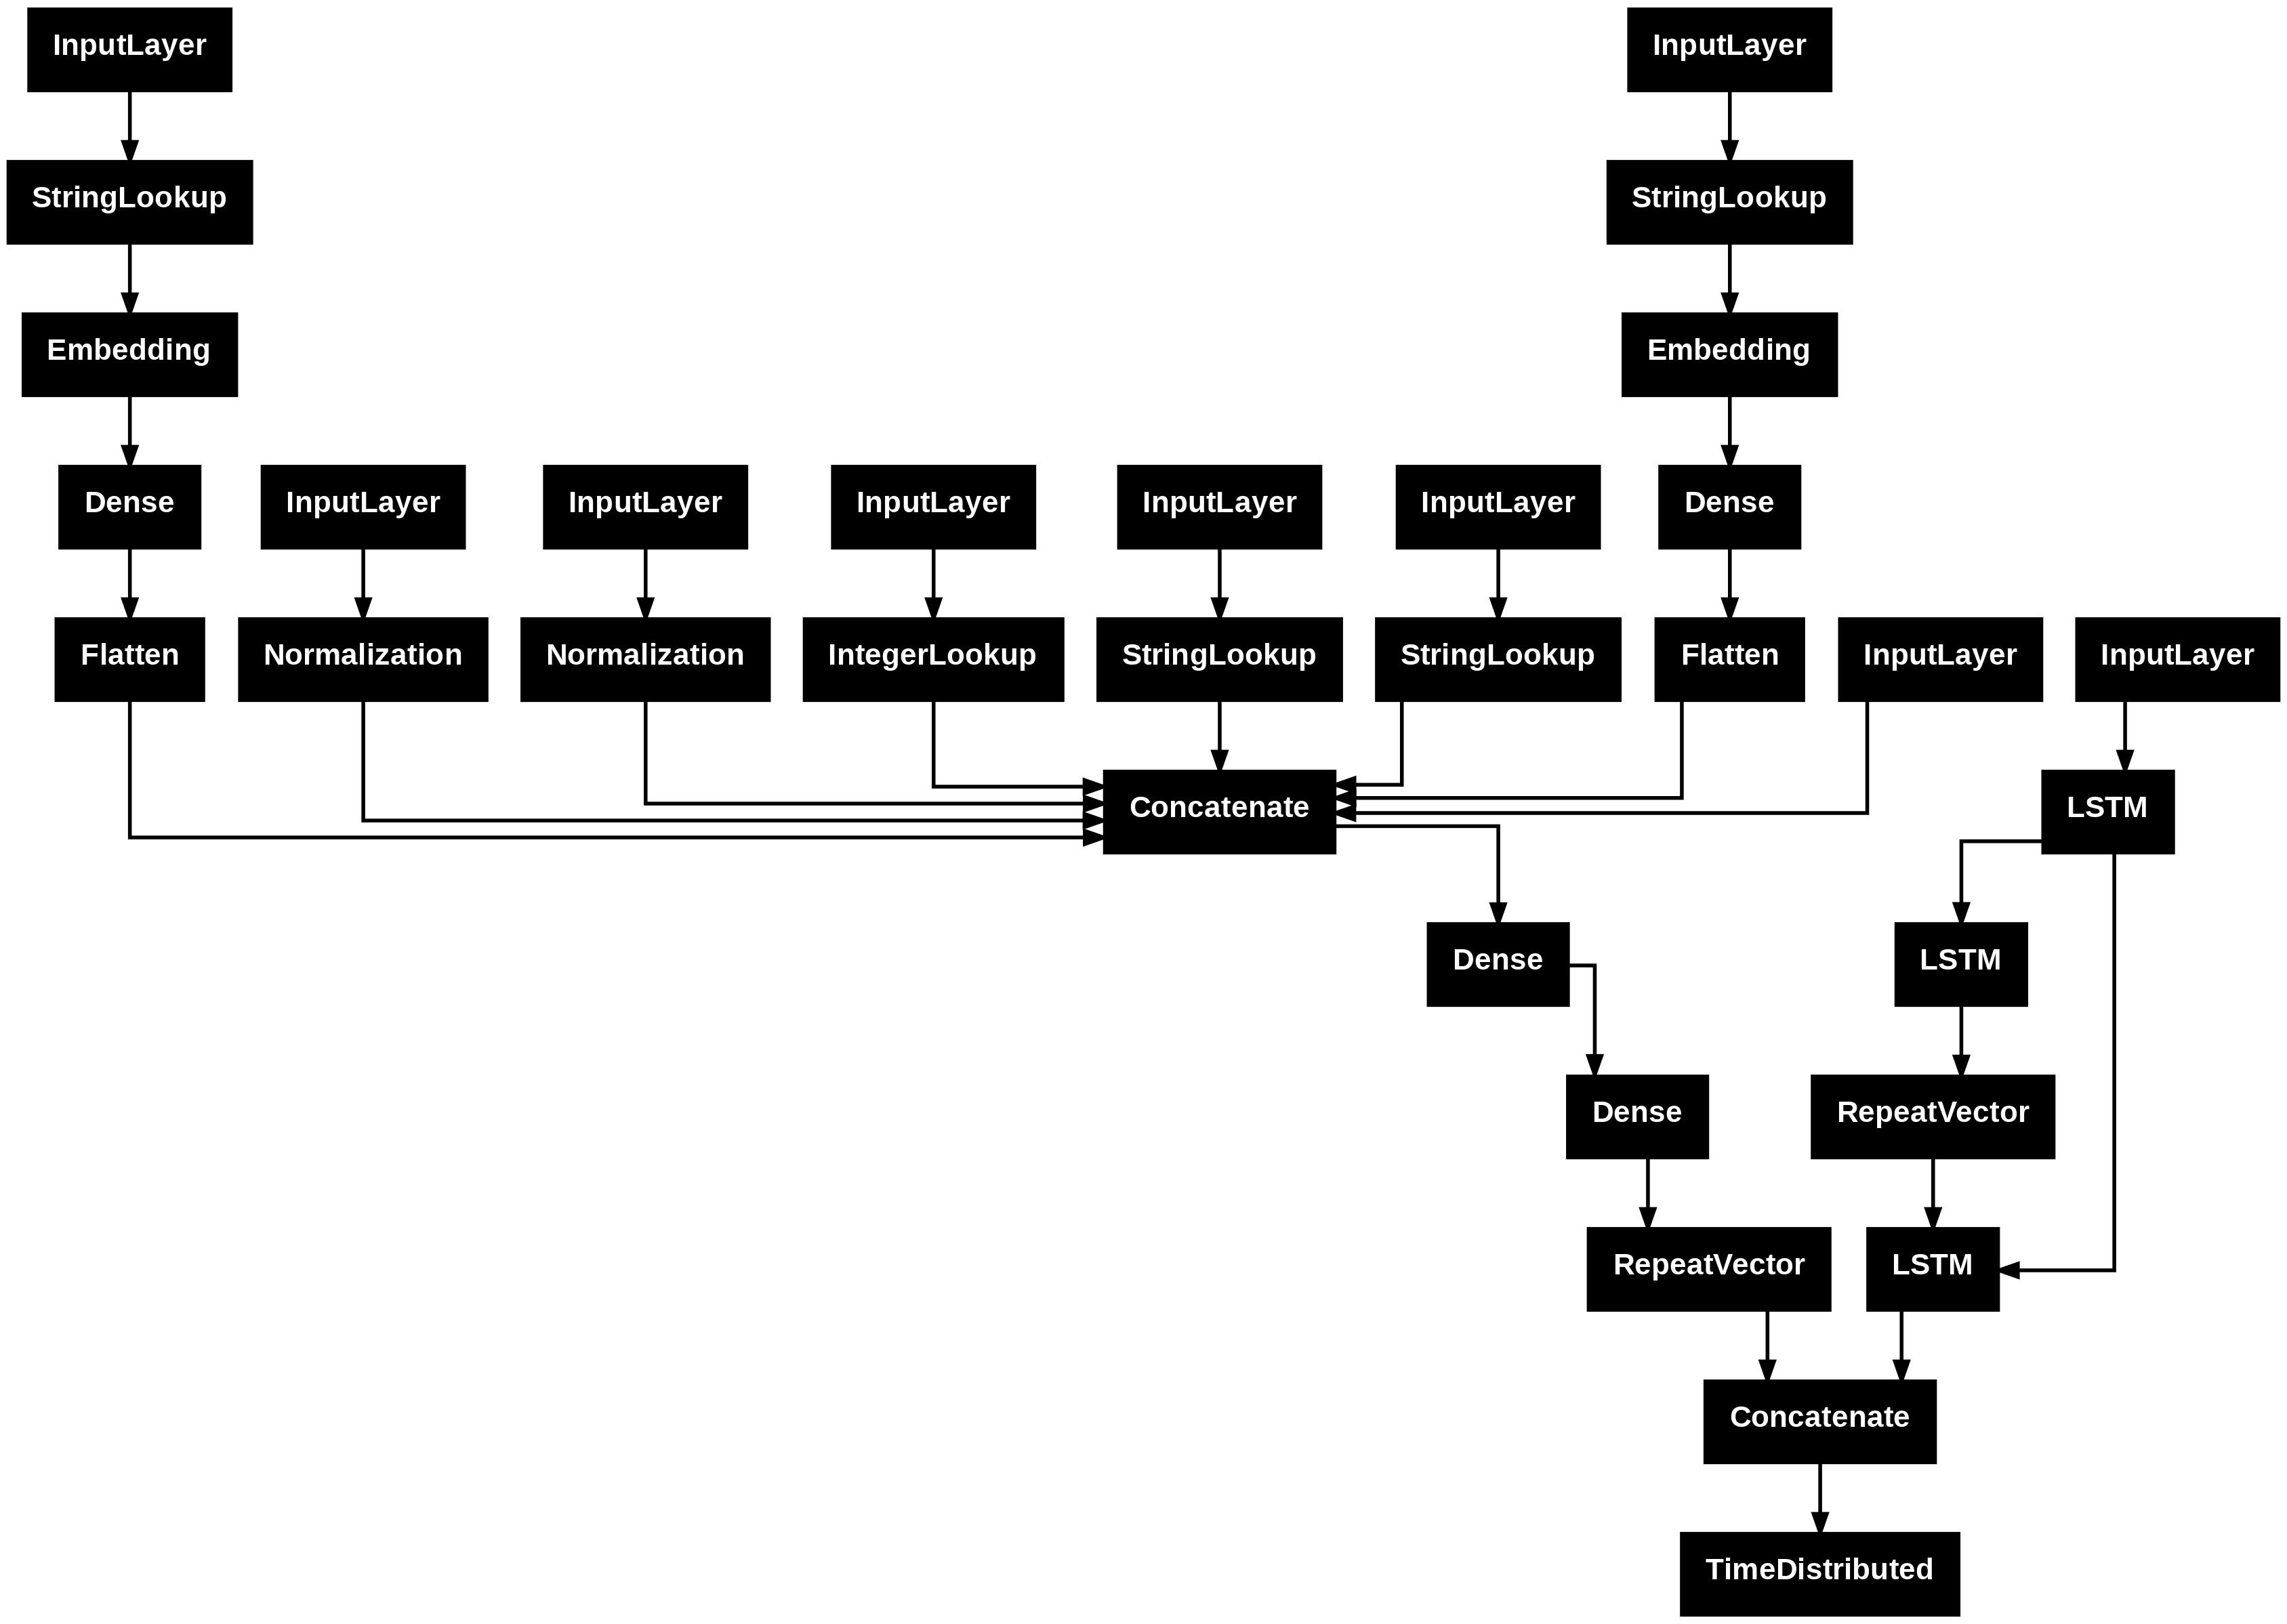

In [12]:
ethalon_model = load_model(output_ethalon_model[0])
tf.keras.utils.plot_model(ethalon_model)

In [13]:
ethalon_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ object_type (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_prep          │ (None, 1)              │              0 │ object_type[0][0]      │
│ (StringLookup)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_prep               │ (None, 1)              │              0 │ street[0][0]           │
│ (StringLookup)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_emb           │ (None, 1, 5)           │            105 │ object_type_prep[0][0] │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_emb (Embedding)    │ (None, 1, 15)          │          3,210 │ street_prep[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ n_floors (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area (InputLayer)         │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_group (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_dense (Dense) │ (None, 1, 2)           │             12 │ object_type_emb[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ floor_group (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ year_group (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_dense (Dense)      │ (None, 1, 8)           │            128 │ street_emb[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LSTM input (InputLayer)   │ (None, 3, 3)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ n_floors_prep             │ (None, 1)              │              3 │ n_floors[0][0]         │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_prep (Normalization) │ (None, 1)              │              3 │ area[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_group_prep           │ (None, 11)             │              0 │ area_group[0][0]       │
│ (IntegerLookup)           │                        │                │                        │
├──────────────────────

 Total params: 23,822 (93.07 KB)

 Trainable params: 7,938 (31.01 KB)

 Non-trainable params: 6 (32.00 B)

 Optimizer params: 15,878 (62.03 KB)